# Introduction

Each column of this dataset has the following information:

- Unnamed: 0: Index
- count: number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when
- hate_speech: number of CF users who judged the tweet to be hate speech
- offensive_language: number of CF users who judged the tweet to be offensive
- neither: number of CF users who judged the tweet to be neither offensive nor non-offensive
- class: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
- tweet: text tweet



Object :
- Determining the best model to predict hate speech


***The dataset can be downloaded*** [here](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?resource=download).

# Import Libraries

In [ ]:
import re
import nltk

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Loading

In [ ]:
df = pd.read_csv("labeled_data.csv")
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
# To provide detailed information about DataFrame df_main
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


# Exploratory Data Analysis (EDA)

In [ ]:
df.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
tweet_processed       0
class_label           0
dtype: int64

In [ ]:
# Mengecek data duplicat
df[df.duplicated()].shape

(0, 9)

In [ ]:
df.nunique()

Unnamed: 0            24783
count                     5
hate_speech               8
offensive_language       10
neither                  10
class                     3
tweet                 24783
tweet_processed       23816
class_label               3
dtype: int64

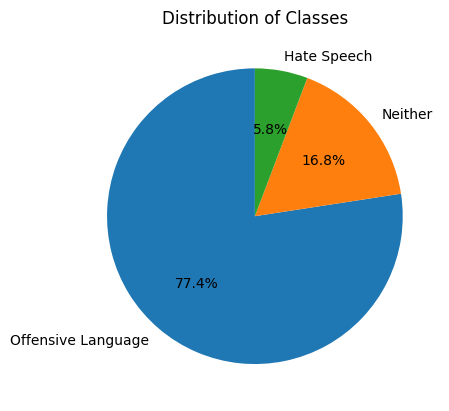

In [ ]:
# Replace the number with the desired label
df['class_label'] = df['class'].map({0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'})

# Count the number of each category
class_counts = df['class_label'].value_counts()

# Create a pie chart
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Classes')
plt.show()

Here I delete tweet text such as symbols and RT so that there are no such things when modeling

In [ ]:
# Define Stopwords
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

In [ ]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stop_words]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [ ]:
# Applying Text Preprocessing to the Dataset

df['tweet_processed'] = df['tweet'].apply(lambda x: text_preprocessing(x))
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_processed
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman n't complain cleaning house amp man alwa...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold tyga dwn bad cuffin dat hoe st p...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,'s muthaf lie right tl trash mine bible script...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",'ve gone broke wrong heart baby drove redneck ...
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like aint fuc...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


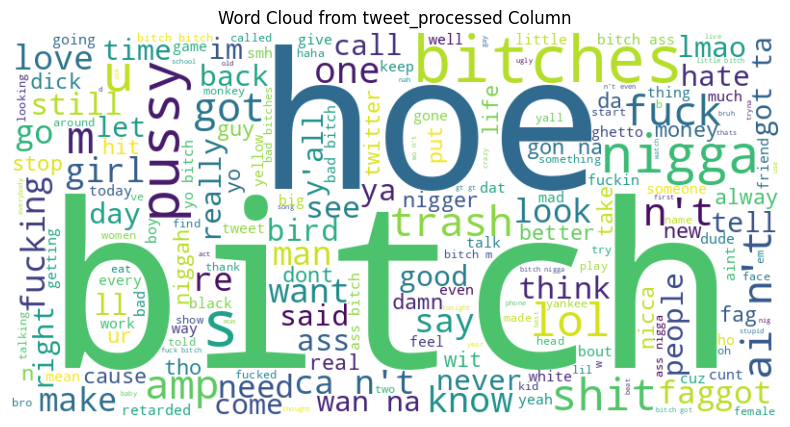

In [ ]:
# Menggabungkan semua teks dalam kolom "tweet_processed" menjadi satu string
all_text = ' '.join(df['tweet_processed'])

# Membuat word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Menampilkan word cloud menggunakan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from tweet_processed Column')
plt.show()

Dari gambaran umum :
- There are no missing values ​​in this data
- There are no duplicate data in this data
- In the class distribution there is the largest percentage, namely offensive language at 77.4%, followed by neither, 16.8% and finally hate speech at 5.8%.
- If you look at the word cloud, the most popular words in the hate speech data are b*tch, h*e, b*itches

# Feature Engineering

In [ ]:
df['label'] = df['class']

In [ ]:
df['label'].value_counts()

1    19190
2     4163
0     1430
Name: label, dtype: int64

In [ ]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.tweet_processed,
                                                    df.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (18958,)
Val Size   :  (2107,)
Test Size  :  (3718,)


In [ ]:
# Change Target to One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<18958x15964 sparse matrix of type '<class 'numpy.int64'>'
	with 133663 stored elements in Compressed Sparse Row format>

In [ ]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  15964
Maximum Sentence Length :  27 tokens


In [ ]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [ ]:
# Example Result

## Document example
print('Document example')
print(df.tweet_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.tweet_processed[0]]))
print('Vector size : ', text_vectorization([df.tweet_processed[0]]).shape)

Document example
woman n't complain cleaning house amp man always take trash

Result of Text Vectorization
tf.Tensor(
[[ 265    3  946 3994  221   20   36   87   85   18    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 27), dtype=int64)
Vector size :  (1, 27)


In [ ]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'bitch',
 'nt',
 'bitches',
 'like',
 's',
 'hoes',
 'pussy',
 'hoe',
 'm',
 'got',
 'ass',
 'get',
 'fuck',
 'u',
 'shit',
 'nigga',
 'trash',
 'lol']

In [ ]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [ ]:
# Example Result

## Document example
print('Document example')
print(df.tweet_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.tweet_processed[0]]))
print('Vector size : ', text_vectorization([df.tweet_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.tweet_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df.tweet_processed[0]])).shape)

Document example
woman n't complain cleaning house amp man always take trash

Result of  Text Vectorization
tf.Tensor(
[[ 265    3  946 3994  221   20   36   87   85   18    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 27), dtype=int64)
Vector size :  (1, 27)

Result of  Embedding
tf.Tensor(
[[[ 4.9222242e-02  3.2646094e-02 -4.6424057e-02 ...  1.8857419e-05
   -2.8051579e-02  3.9971936e-02]
  [-7.8994408e-03 -3.6978565e-02  3.9352011e-02 ... -3.1137669e-02
   -4.1404080e-02 -4.7914516e-02]
  [ 2.5418941e-02 -4.5992889e-02  2.1506473e-04 ... -2.6115552e-03
    2.4373699e-02 -4.5287218e-02]
  ...
  [ 4.6009872e-02  2.0254258e-02 -5.8745742e-03 ... -4.5090090e-02
    1.9253705e-02  3.2922056e-02]
  [ 4.6009872e-02  2.0254258e-02 -5.8745742e-03 ... -4.5090090e-02
    1.9253705e-02  3.2922056e-02]
  [ 4.6009872e-02  2.0254258e-02 -5.8745742e-03 ... -4.5090090e-02
    1.9253705e-02  3.2922056e-02]]], shape=(1, 27, 128), dtype=float32)
Vecto

# Model

In [ ]:
# Model Training using LSTM
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe))

Epoch 1/50
593/593 [==============================] - 78s 117ms/step - loss: 0.1206 - accuracy: 0.9600 - val_loss: 0.6042 - val_accuracy: 0.8799
Epoch 2/50
593/593 [==============================] - 47s 79ms/step - loss: 0.0356 - accuracy: 0.9882 - val_loss: 0.6991 - val_accuracy: 0.8700
Epoch 3/50
593/593 [==============================] - 46s 78ms/step - loss: 0.0244 - accuracy: 0.9909 - val_loss: 0.7581 - val_accuracy: 0.8681
Epoch 4/50
593/593 [==============================] - 48s 81ms/step - loss: 0.0246 - accuracy: 0.9916 - val_loss: 0.7425 - val_accuracy: 0.8647
Epoch 5/50
593/593 [==============================] - 47s 79ms/step - loss: 0.0217 - accuracy: 0.9916 - val_loss: 0.7036 - val_accuracy: 0.8685
Epoch 6/50
593/593 [==============================] - 47s 79ms/step - loss: 0.0153 - accuracy: 0.9942 - val_loss: 0.8293 - val_accuracy: 0.8676
Epoch 7/50
593/593 [==============================] - 48s 81ms/step - loss: 0.0162 - accuracy: 0.9938 - val_loss: 0.8687 - val_accuracy

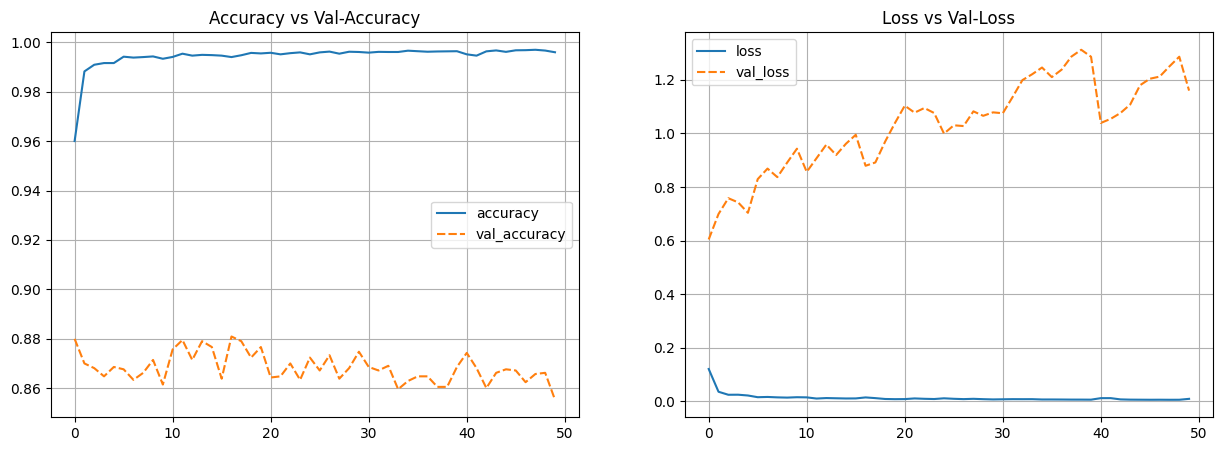

In [ ]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Model Training using LSTM with Transfer Learning
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(3, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe))

Epoch 1/50
593/593 [==============================] - 106s 164ms/step - loss: 0.6718 - accuracy: 0.7733 - val_loss: 0.6675 - val_accuracy: 0.7741
Epoch 2/50
593/593 [==============================] - 96s 162ms/step - loss: 0.6454 - accuracy: 0.7742 - val_loss: 0.6394 - val_accuracy: 0.7731
Epoch 3/50
593/593 [==============================] - 95s 161ms/step - loss: 0.6390 - accuracy: 0.7747 - val_loss: 0.6314 - val_accuracy: 0.7731
Epoch 4/50
593/593 [==============================] - 96s 163ms/step - loss: 0.6262 - accuracy: 0.7742 - val_loss: 0.6372 - val_accuracy: 0.7741
Epoch 5/50
593/593 [==============================] - 95s 160ms/step - loss: 0.6180 - accuracy: 0.7757 - val_loss: 0.6205 - val_accuracy: 0.7784
Epoch 6/50
593/593 [==============================] - 96s 162ms/step - loss: 0.6089 - accuracy: 0.7760 - val_loss: 0.6188 - val_accuracy: 0.7750
Epoch 7/50
593/593 [==============================] - 96s 161ms/step - loss: 0.6048 - accuracy: 0.7779 - val_loss: 0.6088 - val_a

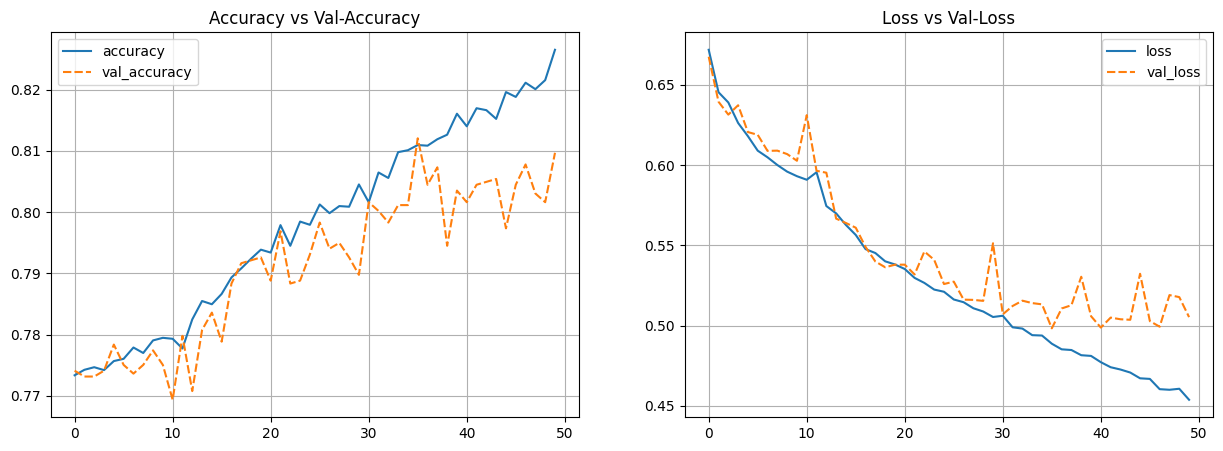

In [ ]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

#Conclusion

From the ltsm model it can be seen that the model is overfit which has equal accuracy 99% meanwhile validation accuracy is around 87 %. When compared with the ltsm model with transfer learning, the model is quite fit at the 36th epoch with an accuracy of 81.1% while the validation accuracy is 81.2%.
There are problems that can cause accuracy to no longer increase because the data used is too unbalanced, there are classes that have 77% of the total data. Meanwhile, non-standard words such as n't, youuu, you've are incomplete when processing data